In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
# sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# Psix

Psix is a computational tool that finds cell-state associated exon usage in single-cell RNA-seq data. The concept of cell-state associated exon usage is inspired in autocorrelation. 

Psix requires three types of information:
* A of $\Psi$ for every exon in every cell.
* A matrix of estimated informative mRNA counts for every exon in every cell.
* An interpretable low-dimensional representation of the cell-state space (e.g., PCA of normalized gene expression, a low-dimensional manifold from a variational autoencoder such as scVI, etc.)

## Psix input


#### 1) STAR-aligned splice junction reads


Psix can estimate the $\Psi$ matrix of cassette exons directly from the output of STAR alignment. The user must provide a directory with the SJ.out.tab for every cell, named as follows: ID.SJ.out.tab, or ID.SJ.out.tab.gz. In addition, Psix requires a dictionary of splice junctions correspond to each cassette exon event. We provide this information for the human and mouse transcriptomes (hg38 and mm10 annotations, respectively). For creating your own dictionary of splice junctions, visit [here](https://github.com/cfbuenabadn/).

Psix can also work with STARsolo output...

#### 2) TPM matrix of gene expression (for non-UMI data only)

Psix requires an estimate of the number of informative mRNA molecules for each exon. In UMI data, this is obtained directly from the splice junction read counts. For non-UMI data such as smart-seq2 data, the user must provide a gene expression matrix with TPM counts for each gene in each cell. Psix implements the [Census normalization](https://www.nature.com/articles/nmeth.4150) in the TPM counts to estimate the number of mRNA molecules captured for each gene. Using information from constitutive introns provudedc in the [dictionary](https://github.com/cfbuenabadn/) of splicing junctions, Psix adjusts these estimates for read coverage as described in [Buen Abad et al., 2020](https://elifesciences.org/articles/54603).


#### 3) Cell-state representation of single-cells

This can be any representation of similarity between cells. E.g., a PCA of normalized gene expression, a pseudotime ordering of cells, or a low-dimenstional manifold of the single-cell gene expression space. Psix does **not** include a gene expression normalization and dimensionality reduction functions. The cell-state space is provided independently by the user.


# Running Psix in mouse midbrain neurons

Here we analyse a smart-seq2 dataset from [Tiklova et al (2019)](https://www.nature.com/articles/s41467-019-08453-1) that follows the development of brain neurons at different stages of development: E13.5, E15.5, E18.5, P0, P7, P15 and P90.

This dataset originally consists of 1699 cells. However, after quality control and normalization, we removed many cells that either had poor coverage, or that were found to be non-neural cells (mostly oligodendrocytes). This left a total of 1067 single neurons. After preprocessing, we observe a clear trajectory of neuron development in this dataset:

<img src="plots/PCA_neurogenesis3D_legend.png" width="500"/>

In [2]:
psix_object = psix.Psix()
psix_object.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        save_files_in='psix_output/'
    )

100%|██████████| 1067/1067 [03:38<00:00,  4.89it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:46<00:00, 22.85it/s]


Successfully processed RNA-seq data


If you specified a directory to save the files, Psix will automatically save the $\Psi$ table and the mRNA per event table in that directory. These can be used to save time the next time, if you want to run Psix again. You can do this by specifying the path to the tables when you create a Psix object:

In [2]:
psix_object = psix.Psix(psi_table = 'psix_output/psi.tab.gz',
                        mrna_table = 'psix_output/mrna.tab.gz')

In [3]:
psix_object.run_psix(latent='data/preprocess/tables/pc3_rd.tab.gz', 
                                n_jobs=25, 
                                n_random_exons=2000, 
                                n_neighbors=100
                               )

Computing cell-cell metric...


100%|██████████| 1067/1067 [00:00<00:00, 3462.55it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:19<00:00, 105.19it/s] 


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:33<00:00, 20.55s/it]  


Successfully estimated p-values


In [5]:
psix_object.psix_results.head(n=10)

,psix_score,pvals,qvals
Mapt_1,2.709381,0.0005,0.001879
Ndrg4_1,2.359093,0.0005,0.001879
Dbn1_1,2.302729,0.0005,0.001879
Mapt_3,1.964202,0.0005,0.001879
Gabrg2_1,1.896363,0.0005,0.001879
Cadm1_10,1.576869,0.0005,0.001879
Ncam1_6,1.456006,0.0005,0.001879
Dst_5,1.449287,0.0005,0.001879
Cadm1_3,1.411169,0.0005,0.001879
Morf4l2_7,1.363965,0.0005,0.001879


In [8]:
psix_object = psix.Psix(psix_object = 'psix_object')

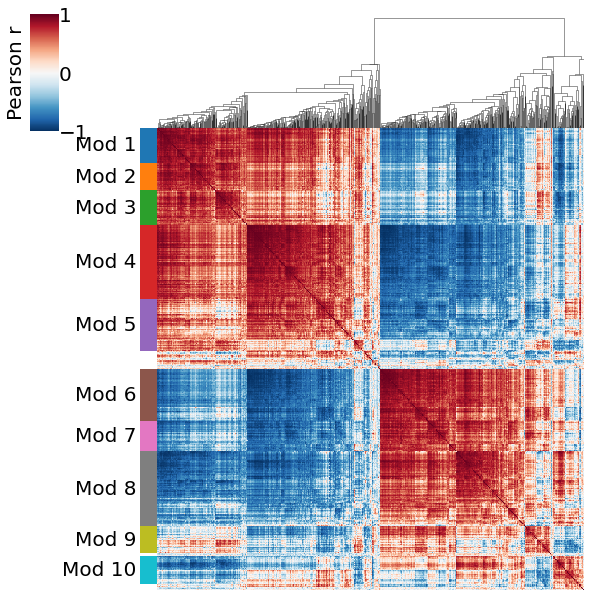

In [9]:
psix_object.compute_modules(min_gene_threshold=30, 
                            fdr_threshold=None, 
                            z_threshold=0.3, 
                            core_only=False,
                            n_neighbors = 100,
                            weight_metric=True,
                            plot = True,
                            z_cmap='RdBu_r', 
                            yticklabels=False,
                            plot_name = ''
                           )

In [2]:
psix_object.save_psix_object(psix_dir = 'psix_object', overwrite = False)

NameError: name 'psix_object' is not defined

Successfully computed neighbors


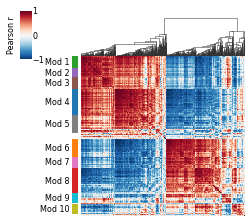

In [5]:
psix_object.compute_neighbors_psi(latent='data/preprocess/tables/pc3_rd.tab.gz', n_neighbors=100)
psix_object.compute_modules(min_gene_threshold=30)
modules = psix_object.plot_correlation_modules(plot_name = 'plots/exon_modules.png')

In [6]:
'psi' in psix_object.adata.uns

True

In [4]:
rd_p90 = pd.read_csv('data/preprocess/tables/p90_rd.tab.gz', sep='\t', index_col=0)

In [5]:
psix_p90 = psix.Psix()
psix_p90.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = rd_p90.index,
        save_files_in='psix_p90_output/'
    )

100%|██████████| 290/290 [01:03<00:00,  4.59it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 290/290 [00:13<00:00, 21.77it/s]


Successfully processed RNA-seq data


In [9]:
psix_p90.run_psix(latent='data/preprocess/tables/p90_rd.tab.gz', n_jobs=25, 
                                n_random_exons=10000, n_neighbors=30)#, pvals_bins=10)

Computing cell-cell metric...


100%|██████████| 290/290 [00:00<00:00, 19884.39it/s]

Successfully computed cell-cell metric
Computing Psix score in 2115 exons



100%|██████████| 2115/2115 [00:07<00:00, 268.74it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [11:56<00:00, 28.66s/it]  


Successfully estimated p-values


In [6]:
psix_p90.run_psix(latent='data/preprocess/tables/p90_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=30)#, pvals_bins=10)

Computing cell-cell metric...


100%|██████████| 290/290 [00:00<00:00, 22205.45it/s]

Successfully computed cell-cell metric
Computing Psix score in 2115 exons



100%|██████████| 2115/2115 [00:07<00:00, 284.19it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [02:26<00:00,  5.88s/it]


Successfully estimated p-values


In [7]:
sig_exons_p90 = psix_p90.psix_results.loc[((psix_p90.psix_results.qvals <= 0.05) & (psix_p90.psix_results.psix_score > 0))].index


In [8]:
len(sig_exons_p90)

78

In [12]:
psix_p90.save_psix_object(psix_dir = 'psix_object_p90', overwrite = True)

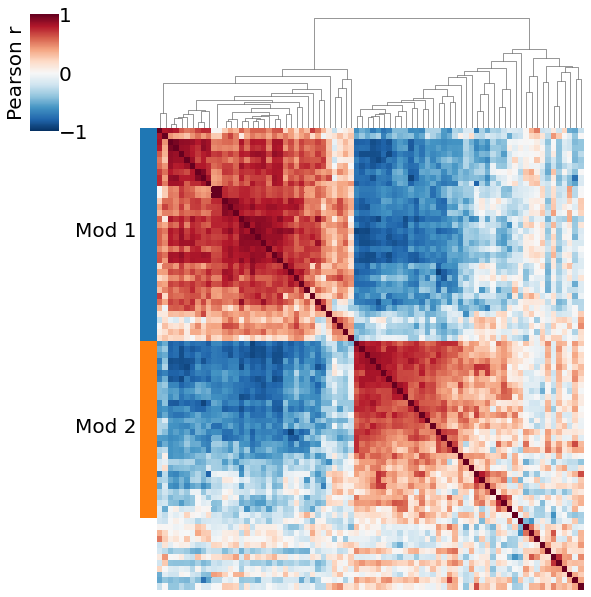

In [10]:
psix_p90.compute_modules(min_gene_threshold=30, 
                            fdr_threshold=None, 
                            z_threshold=0.1, 
                            core_only=False,
                            n_neighbors = 100,
                            weight_metric=True,
                            plot = True,
                            z_cmap='RdBu_r', 
                            yticklabels=False,
                            plot_name = ''
                           )

In [12]:
sj_p1.columns

Index(['SRR7409064', 'SRR7409071', 'SRR7409072', 'SRR7409074', 'SRR7409077',
       'SRR7409078', 'SRR7409081', 'SRR7409085', 'SRR7409086', 'SRR7409087',
       ...
       'SRR7409564', 'SRR7409566', 'SRR7409567', 'SRR7409568', 'SRR7409570',
       'SRR7409571', 'SRR7409573', 'SRR7409574', 'SRR7409575', 'SRR7409576'],
      dtype='object', length=242)

In [2]:
sj_p1 = pd.read_csv('data/preprocess/tables/p1_splice_junctions_filtered.tab.gz',
                    sep='\t', index_col=0)

psix_p1 = psix.Psix()
psix_p1.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = sj_p1.columns,
        save_files_in='psix_p1_output/',
        minPsi = 0.001,
        min_observed = 0.001,
    )

100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 242/242 [00:11<00:00, 21.97it/s]


Successfully processed RNA-seq data


In [3]:
sj_e13 = pd.read_csv('data/preprocess/tables/e13_splice_junctions_filtered.tab.gz',
                    sep='\t', index_col=0)

psix_e13 = psix.Psix()
psix_e13.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = sj_e13.columns,
        save_files_in='psix_e13_output/',
        minPsi = 0.001,
        min_observed = 0.001,
    )

100%|██████████| 240/240 [00:33<00:00,  7.10it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 240/240 [00:08<00:00, 27.18it/s]


Successfully processed RNA-seq data


In [16]:
p90_cells = rd_p90.index
p1_cells = sj_p1.columns
e13_cells = sj_e13.columns

In [17]:
psix_p1.compute_neighbors_psi(latent='data/preprocess/tables/p1_rd.tab.gz', n_neighbors=30)
psix_e13.compute_neighbors_psi(latent='data/preprocess/tables/e13_rd.tab.gz', n_neighbors=30)

Successfully computed neighbors
Successfully computed neighbors


0.882019885492593


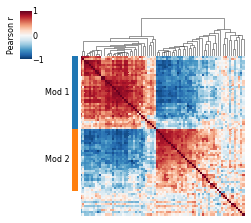

In [15]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_p90.adata.uns['psi'].columns

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_p90[0].index], bwow_p90[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_p90_prueba.png', shrink_by=1#/0.5
)

p90_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(p90_eig[0]/np.sum(p90_eig))

In [32]:
p90_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
p90_eig[0]/np.sum(p90_eig)

0.882019885492593

18.87344986547189


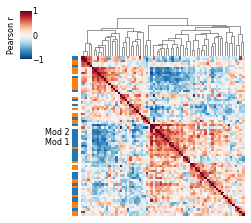

In [18]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_p1.adata.uns['psi'].columns

background_psi = psix_p1.adata.uns['neighbors_psi'].mask(psix_p1.adata.uns['psi'].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p1 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_p1[0].index], bwow_p1[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_p1_prueba.png', shrink_by=1#/0.5
)

print(np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0][0])

In [19]:
p1_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
p1_eig[0]/np.sum(p1_eig)

0.5456391992622472

0.3887988927799862


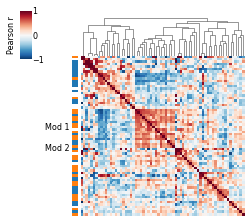

In [21]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_e13.adata.uns['psi'].columns

background_psi = psix_e13.adata.uns['neighbors_psi'].mask(psix_e13.adata.uns['psi'].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_e13 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_e13[0].index], bwow_e13[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_e13_prueba.png', shrink_by=1#/0.5
)

e13_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(e13_eig[0]/np.sum(e13_eig))

In [30]:
e13_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
e13_eig[0]/np.sum(e13_eig)

0.6145362050248433

In [33]:
psix_extended = psix.Psix()
psix_extended.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        save_files_in='psix_extended/',
        minJR = 1,
        minCell = 1,
        minPsi = 0.01,
        min_observed = 0.01,
    )

100%|██████████| 1067/1067 [02:55<00:00,  6.07it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:47<00:00, 22.66it/s]


Successfully processed RNA-seq data


In [ ]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_p1.adata.uns['psi'].columns

background_psi = psix_p1.adata.uns['neighbors_psi'].mask(psix_p1.adata.uns['psi'].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p1 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_p1[0].index], bwow_p1[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_p1.png', shrink_by=1#/0.5
)

print(np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0][0])

In [41]:
def get_all_exons_neighbors(psi, cell_metric):
    
    neighbors_psi = []
    
    for exon_psi in psi.T:
        neighbors_psi.append(get_exon_neighbors_psi(exon_psi, cell_metric))
        
    return np.array(neighbors_psi)


def get_background(psi, metric):
#     psi = np.array(self.adata.uns['psi'])
    
    neighbors_psi = pd.DataFrame(get_all_exons_neighbors(np.array(psi), metric),
                                 columns = psi.index,
                                 index = psi.columns)
    return neighbors_psi



import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm 
from numba import jit

def compute_cell_metric_light(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(manifold.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric


@jit(nopython=True)
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


@jit(nopython=True)
def get_exon_neighbors_psi(observed_psi_array, cell_metric):
    psi_a_array = []
    for i in range(len(observed_psi_array)):
#         psi_o = observed_psi_array[i]
                    
#         psi_o_array.append(psi_o)

        neighbors = cell_metric[0][i]
        weights = cell_metric[1][i]

        psi_sum = 0
        weight_sum = 0
        for j in range(len(neighbors)):
            psi_n = observed_psi_array[neighbors[j]]
            if not np.isnan(psi_n):
                psi_sum += (psi_n * weights[j])
                weight_sum += weights[j]
        if weight_sum > 0:
            psi_a_array.append(psi_sum/weight_sum)
        else:
            psi_a_array.append(np.nan)
                
    return psi_a_array


latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)

cell_metric = compute_cell_metric_light(pd.DataFrame(latent.loc[p90_cells][['PC_1', 'PC_2', 'PC_3']]), n_neighbors=30)
neighbors_psi_p90 = get_background(psix_extended.adata.uns['psi'].loc[p90_cells], cell_metric)
neighbors_psi_p90_z = pd.DataFrame(zscore(neighbors_psi_p90, axis=1, nan_policy='omit'),
                                   columns = neighbors_psi_p90.columns,
                                   index = neighbors_psi_p90.index).fillna(0)

cell_metric = compute_cell_metric_light(pd.DataFrame(latent.loc[p1_cells][['PC_1', 'PC_2', 'PC_3']]), n_neighbors=30)
neighbors_psi_p1 = get_background(psix_extended.adata.uns['psi'].loc[p1_cells], cell_metric)
neighbors_psi_p1_z = pd.DataFrame(zscore(neighbors_psi_p1, axis=1, nan_policy='omit'),
                                   columns = neighbors_psi_p1.columns,
                                   index = neighbors_psi_p1.index).fillna(0)


cell_metric = compute_cell_metric_light(pd.DataFrame(latent.loc[e13_cells][['PC_1', 'PC_2', 'PC_3']]), n_neighbors=30)
neighbors_psi_e13 = get_background(psix_extended.adata.uns['psi'].loc[e13_cells], cell_metric)
neighbors_psi_e13_z = pd.DataFrame(zscore(neighbors_psi_e13, axis=1, nan_policy='omit'),
                                   columns = neighbors_psi_e13.columns,
                                   index = neighbors_psi_e13.index).fillna(0)

100%|██████████| 240/240 [00:00<00:00, 20310.58it/s]


0.49371578122745274


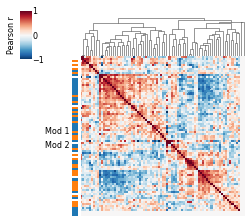

In [75]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & neighbors_psi_p1.index

background_psi = neighbors_psi_p1.T.mask(psix_extended.adata.uns['psi'].loc[neighbors_psi_p1.T.index, 
                                                                          neighbors_psi_p1.T.columns].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p1 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_p1[0].index], bwow_p1[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_p1.png', shrink_by=1#/0.5
)

p1_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(p1_eig[0]/np.sum(p1_eig))

In [50]:
p1_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
p1_eig[0]/np.sum(p1_eig)

0.49371578122745274

0.30491365422603206


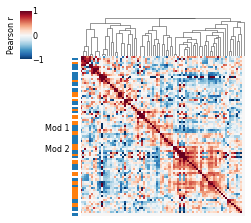

In [77]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & neighbors_psi_e13.index

background_psi = neighbors_psi_e13.T.mask(psix_extended.adata.uns['psi'].loc[neighbors_psi_e13.T.index, 
                                                                          neighbors_psi_e13.T.columns].isna()).T
# exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_e13 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_e13[0].index], bwow_e13[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_e13.png', shrink_by=1#/0.5
)

e13_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(e13_eig[0]/np.sum(e13_eig))

In [52]:
e13_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
e13_eig[0]/np.sum(e13_eig)

0.30491365422603206

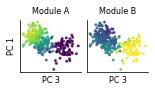

In [22]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

ax_1.scatter(latent.loc[p90_cells].PC_3, latent.loc[p90_cells].PC_1,
           c = zscore(psix_p90.adata.uns['neighbors_psi'].T.loc[bwow_p90[0].loc[bwow_p90[0] == 1].index],
       axis=1, nan_policy='omit').mean(axis=0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)




ax_2.scatter(latent.loc[p90_cells].PC_3, latent.loc[p90_cells].PC_1,
           c = zscore(psix_p90.adata.uns['neighbors_psi'].T.loc[bwow_p90[0].loc[bwow_p90[0] == 2].index],
       axis=1, nan_policy='omit').mean(axis=0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

plt.savefig('plots/p90_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.show()

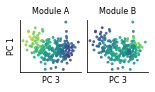

In [34]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

idx_1 = bwow_p90[0].loc[bwow_p90[0] == 1].index & psix_p1.adata.uns['neighbors_psi'].columns


ax_1.scatter(latent.loc[p1_cells].PC_3, latent.loc[p1_cells].PC_1,
           c = np.nanmean(zscore(psix_p1.adata.uns['neighbors_psi'].T.loc[idx_1],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)



idx_2 = bwow_p90[0].loc[bwow_p90[0] == 2].index & psix_p1.adata.uns['neighbors_psi'].columns


ax_2.scatter(latent.loc[p1_cells].PC_3, latent.loc[p1_cells].PC_1,
           c = np.nanmean(zscore(psix_p1.adata.uns['neighbors_psi'].T.loc[idx_2],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

plt.savefig('plots/p1_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.show()

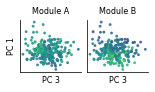

In [36]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

idx_1 = bwow_p90[0].loc[bwow_p90[0] == 1].index & psix_e13.adata.uns['neighbors_psi'].columns


ax_1.scatter(latent.loc[e13_cells].PC_3, latent.loc[e13_cells].PC_1,
           c = np.nanmean(zscore(psix_e13.adata.uns['neighbors_psi'].T.loc[idx_1],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)



idx_2 = bwow_p90[0].loc[bwow_p90[0] == 2].index & psix_e13.adata.uns['neighbors_psi'].columns


ax_2.scatter(latent.loc[e13_cells].PC_3, latent.loc[e13_cells].PC_1,
           c = np.nanmean(zscore(psix_e13.adata.uns['neighbors_psi'].T.loc[idx_2],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

plt.savefig('plots/e13_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.show()

In [63]:
def nan_pearsonr(x, y):
    non_nan = y.dropna().index
    if len(non_nan) < 15:
        return (np.nan, 1)
    return pearsonr(x.loc[non_nan], y.loc[non_nan])

norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)[latent.index]

def plot_rbp(rbp_name):
    mod1_p90_cor = []
    mod1_p1_cor = []
    mod1_e13_cor = []
    for exon in p90_modules.loc[p90_modules == 1].index:
        mod1_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_extended.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        mod1_p1_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_extended.adata.uns['psi'].loc[p1_cells, exon])[0]
        )

        mod1_e13_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_extended.adata.uns['psi'].loc[e13_cells, exon])[0]
        )

    mod2_p90_cor = []
    mod2_p1_cor = []
    mod2_e13_cor = []
    for exon in p90_modules.loc[p90_modules == 2].index:
        mod2_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_extended.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        mod2_p1_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_extended.adata.uns['psi'].loc[p1_cells, exon])[0]
        )

        mod2_e13_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_extended.adata.uns['psi'].loc[e13_cells, exon])[0]
        )    
        
    abs_max = np.max((np.nanmax(np.abs(mod1_e13_cor)), 0))
    abs_max = np.max((np.nanmax(np.abs(mod2_e13_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p90_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p90_cor)), abs_max))
        
        
    colors = list(plt.get_cmap('tab10').colors)
    fig = plt.figure(figsize=(6/2.4, 4/2.4))
    ax = fig.add_subplot(111)

    ax.grid(False)

    ax.plot([-0.5, 2.5], [0, 0], 'r--')

    ax.scatter(np.random.normal(0.1, 0.05, len(mod1_e13_cor)), mod1_e13_cor, 
               c=[colors[0]]*len(mod1_e13_cor), alpha=0.75, edgecolor=None, s=20)
    ax.scatter(np.random.normal(-0.1, 0.05, len(mod2_e13_cor)), mod2_e13_cor, 
               c=[colors[1]]*len(mod2_e13_cor), alpha=0.75, edgecolor=None, s=20)

    ax.scatter(np.random.normal(1.1, 0.05, len(mod1_p1_cor)), mod1_p1_cor, 
               c=[colors[0]]*len(mod1_p1_cor), alpha=0.75, edgecolor=None, s=20)
    ax.scatter(np.random.normal(0.9, 0.05, len(mod2_p1_cor)), mod2_p1_cor, 
               c=[colors[1]]*len(mod2_p1_cor), alpha=0.75, edgecolor=None, s=20)

    ax.scatter(np.random.normal(2.1, 0.05, len(mod1_p90_cor)), mod1_p90_cor, 
               c=[colors[0]]*len(mod1_p90_cor), alpha=0.75, edgecolor=None, s=20)
    ax.scatter(np.random.normal(1.9, 0.05, len(mod2_p90_cor)), mod2_p90_cor, 
               c=[colors[1]]*len(mod2_p90_cor), alpha=0.75, edgecolor=None, s=20)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['E13.5', 'P1', 'P90'], size=12)

    ax.set_ylabel('Pearson r', size=12)

    ax.tick_params(labelsize=12, length=5)
    ax.set_title(rbp_name, fontsize=12)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.ylim((-abs_max - 0.05, abs_max + 0.05))

    plt.savefig('plots/' + rbp_name + '_correlations.png', bbox_inches='tight', res=20000, dpi =2000)
    
    
    modules_corr = pd.DataFrame()
    modules_corr['E13.5'] = [np.nanmean(mod1_e13_cor), np.nanmean(mod2_e13_cor)]
    modules_corr['P1'] = [np.nanmean(mod1_p1_cor), np.nanmean(mod2_p1_cor)]
    modules_corr['P90'] = [np.nanmean(mod1_p90_cor), np.nanmean(mod2_p90_cor)]
    
    modules_corr.index = ['Mod1', 'Mod2']
    #list(p90_modules.loc[p90_modules == 1].index) + list(p90_modules.loc[p90_modules == 2].index)
    
    return modules_corr

p90_modules = bwow_p90[0]

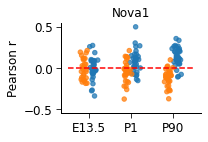

In [65]:
modules_corr_rbfox1 = plot_rbp('Nova1')

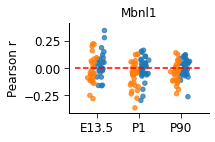

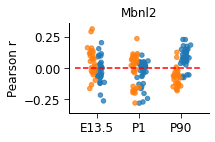

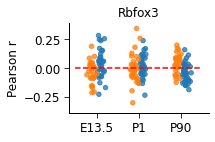

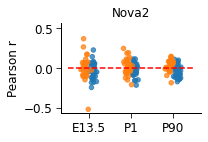

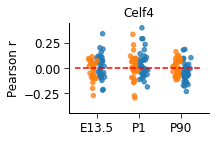

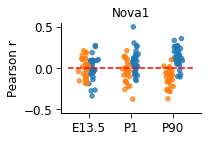

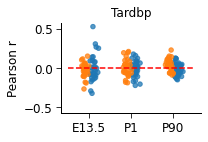

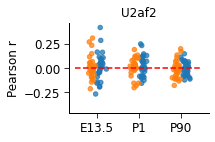

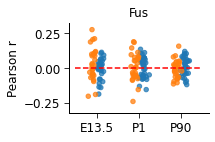

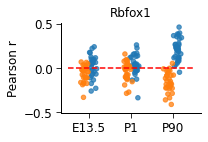

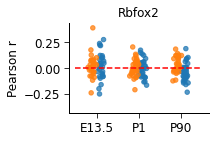

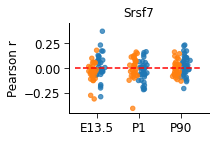

In [66]:
rbp_list = ['Mbnl1', 'Mbnl2', 'Rbfox3', 'Nova2', 'Celf4', 'Nova1', 'Tardbp', 'U2af2', 'Fus', 'Rbfox1', 'Rbfox2', 'Srsf7']


mod_diff = pd.DataFrame()
for rbp in rbp_list:
    modules_corr_rbp = plot_rbp(rbp)
    mod_diff[rbp] = modules_corr_rbp.loc['Mod1'] - modules_corr_rbp.loc['Mod2']

In [71]:
def plot_rbp_ax_uniform(rbp_name, ax):
    mod1_p90_cor = []
    mod1_p1_cor = []
    mod1_e13_cor = []
    
    for exon in p90_modules.loc[p90_modules == 1].index:
        mod1_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_extended.adata.uns['psi'].loc[p90_cells, exon])[0]
        )
        
        mod1_p1_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_extended.adata.uns['psi'].loc[p1_cells, exon])[0]
        )

        mod1_e13_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_extended.adata.uns['psi'].loc[e13_cells, exon])[0]
        )

    mod2_p90_cor = []
    mod2_p1_cor = []
    mod2_e13_cor = []
    
    nova_colors = []
#     nova_colors_p1 = []
#     nova_colors_p90 = []
    
    for exon in p90_modules.loc[p90_modules == 2].index:
        
        if exon == 'Nova1_1':
            nova_colors.append('red')
        else:
            nova_colors.append(None)
        
        
        mod2_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_extended.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        mod2_p1_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_extended.adata.uns['psi'].loc[p1_cells, exon])[0]
        )

        mod2_e13_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_extended.adata.uns['psi'].loc[e13_cells, exon])[0]
        )    
        
    abs_max = np.max((np.nanmax(np.abs(mod1_e13_cor)), 0))
    abs_max = np.max((np.nanmax(np.abs(mod2_e13_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p90_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p90_cor)), abs_max))
        
        
    colors = list(plt.get_cmap('tab10').colors)
#     fig = plt.figure(figsize=(6/2.4, 4/2.4))
#     ax = fig.add_subplot(111)

    ax.grid(False)

    ax.plot([-0.5, 2.5], [0, 0], 'r--')
    
    ax.set_ylim((-0.75, 0.75))
    
    ax.scatter(np.linspace(0,0.25, len(mod1_e13_cor)), mod1_e13_cor, 
               c=[colors[0]]*len(mod1_e13_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(-0.25, 0, len(mod2_e13_cor)), mod2_e13_cor, 
               c=[colors[1]]*len(mod2_e13_cor), alpha=0.75, linewidth=0, s=12)

    ax.scatter(np.linspace(1, 1.25, len(mod1_p1_cor)), mod1_p1_cor, 
               c=[colors[0]]*len(mod1_p1_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(0.75, 1, len(mod2_p1_cor)), mod2_p1_cor, 
               c=[colors[1]]*len(mod2_p1_cor), alpha=0.75, linewidth=0, s=12)

    ax.scatter(np.linspace(2, 2.25, len(mod1_p90_cor)), mod1_p90_cor, 
               c=[colors[0]]*len(mod1_p90_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(1.75, 2, len(mod2_p90_cor)), mod2_p90_cor, 
               c=[colors[1]]*len(mod2_p90_cor), alpha=0.75, linewidth=0, s=12)
    
    
#     print(len(nova_colors))
#     print(len())
    
#     ax.scatter(np.linspace(-0.25, 0, len(mod2_e13_cor)), mod2_e13_cor, 
#                c=nova_colors, alpha=0.75, linewidth=0, s=12)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['E13.5', 'P1', 'P90'], size=8, rotation=45)

    ax.set_ylabel('Pearson r', size=8)

    ax.tick_params(labelsize=8, length=5)
    ax.set_title(rbp_name, fontsize=8)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.set_ylim((-abs_max - 0.05, abs_max + 0.05))

#     plt.savefig('plots/' + rbp_name + '_correlations.png', bbox_inches='tight', res=12000, dpi =1200)
    
    
    modules_corr = pd.DataFrame()
    modules_corr['E13.5'] = [np.nanmean(mod1_e13_cor), np.nanmean(mod2_e13_cor)]
    modules_corr['P1'] = [np.nanmean(mod1_p1_cor), np.nanmean(mod2_p1_cor)]
    modules_corr['P90'] = [np.nanmean(mod1_p90_cor), np.nanmean(mod2_p90_cor)]
    
    modules_corr.index = ['Mod1', 'Mod2']
    #list(p90_modules.loc[p90_modules == 1].index) + list(p90_modules.loc[p90_modules == 2].index)
    
#     return modules_corr

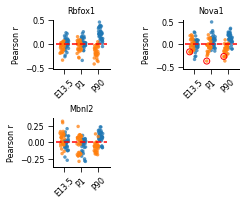

In [72]:
from itertools import product
from matplotlib.gridspec import GridSpec


rbp_list = list(mod_diff.T.abs().sort_values('P90').index[::-1])

fig = plt.figure(figsize=(8/2.4, 6.5/2.4))
gs = GridSpec(2,2)
gs.update(wspace=1.3, hspace=1)

i = 0

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])
plot_rbp_ax_uniform('Rbfox1', ax1)
plot_rbp_ax_uniform('Nova1', ax2)
plot_rbp_ax_uniform('Mbnl2', ax3)
# plot_rbp_ax_uniform('Mbnl2', ax4)

ax2.scatter([-0.25, 0.75, 1.75],
           [nan_pearsonr(norm_expression.loc['Nova1', e13_cells], psix_extended.adata.uns['psi'].loc[e13_cells, 'Nova1_1'])[0],
           nan_pearsonr(norm_expression.loc['Nova1', p1_cells], psix_extended.adata.uns['psi'].loc[p1_cells, 'Nova1_1'])[0],
           nan_pearsonr(norm_expression.loc['Nova1', p90_cells], psix_extended.adata.uns['psi'].loc[p90_cells, 'Nova1_1'])[0]],
           color="none", edgecolor="red")
#            c = 'darkred', linewidth=1, color=None)

plt.show()  
# plt.savefig('plots/rbp_p90_module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)